In [ ]:
import re
import json
from openai import OpenAI
from hybird_search import HybridRetriever
import pandas as pd
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

In [ ]:
# ---------- Prepare ----------
documents = json.load(open("data/labor_law/labor_law_parsed.json", encoding="utf-8"))
df_ground_truth = pd.read_csv("data/ground-truth-data.csv")
ground_truth = df_ground_truth.to_dict(orient='records')
hybrid = HybridRetriever(documents)

In [111]:

model_name = 'intfloat/multilingual-e5-base'
cosin_model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [84]:
doc_idx = {d['index']: d for d in documents}

In [85]:
def highlight_articles(text: str):
    return re.sub(r"(المادة\s+[^\s،.]+|Article\s+\d+)", r"**\1**", text)

In [87]:
# ---------- Core Answer ----------
def generate_answer(query: str, context: str, api_key: str, model : str) -> str:
    """Generate an answer using a per-user OpenAI API key."""
    client = OpenAI(api_key=api_key)

    prompt = f"""أنت مساعد ذكي متخصص في نظام العمل السعودي.
    اعتمد فقط على نصوص المادة أدناه للإجابة على السؤال بدقة وبالعربية.

    نصوص المادة:
    \"\"\"{context}\"\"\"

    السؤال: {query}

    الإجابة:"""

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
    )
    answer = response.choices[0].message.content.strip()
    return highlight_articles(answer)


In [88]:
# ---------- Main Entry ----------
def llm(query: str, api_key: str, model : str):
    """Answer a policy question, optionally using employee data and user-provided key."""

    retriever = hybrid

    # Retrieve context
    results = retriever.retrieve(query)
    if not results:
        msg = "❌ لم يتم العثور على مواد ذات صلة."
        return msg

    context = "\n\n".join(r["content"] for r in results)
    answer = generate_answer(query, context, api_key , model)
    return answer

In [89]:
model = "gpt-4o-mini"
gpt_4o_answers = {}

In [91]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in gpt_4o_answers:
        continue

    answer_llm = llm(rec['question'],API_KEY,model)
    answer_orig = rec['article_orig']

    gpt_4o_answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'index': rec['index'],
        'article_number': rec['article_number']
    }

  0%|          | 0/1245 [00:00<?, ?it/s]

In [92]:
results_gpt4o = [None] * len(ground_truth)

for i, val in gpt_4o_answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [93]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [94]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

In [98]:
gpt_3o_model = "gpt-3.5-turbo"
gpt_3o_answers = {}

In [99]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in gpt_3o_answers:
        continue

    answer_llm = llm(rec['question'],API_KEY,gpt_3o_model)
    answer_orig = rec['article_orig']

    gpt_3o_answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'index': rec['index'],
        'article_number': rec['article_number']
    }

  0%|          | 0/1245 [00:00<?, ?it/s]

In [102]:
results_gpt35 = [None] * len(ground_truth)

for i, val in gpt_3o_answers.items():
    results_gpt35[i] = val.copy()
    results_gpt35[i].update(ground_truth[i])
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

## Cosine similarity

In [112]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = cosin_model.encode(answer_llm)
    v_orig = cosin_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

gpt-4o-mini

In [114]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [115]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1245 [00:00<?, ?it/s]

In [116]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1245.000000
mean        0.862157
std         0.040849
min         0.727516
25%         0.838518
50%         0.861274
75%         0.884288
max         0.995090
Name: cosine, dtype: float64

gpt-3.5-turbo

In [117]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1245 [00:00<?, ?it/s]

In [118]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1245.000000
mean        0.857329
std         0.041789
min         0.715492
25%         0.831163
50%         0.857199
75%         0.884257
max         0.995493
Name: cosine, dtype: float64

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\zaina\AppData\Local\Temp\ipykernel_20280\18041136.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o-mini')
C:\Users\zaina\AppData\Local\Temp\ipykernel_20280\18041136.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='35o-turbo'

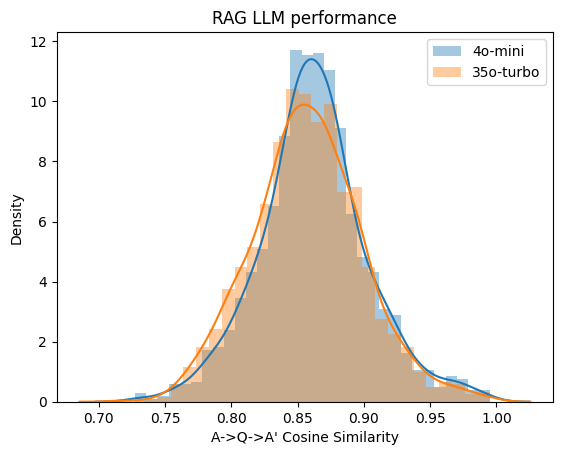

In [123]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_gpt4o['cosine'], label='4o-mini')
sns.distplot(df_gpt35['cosine'], label='35o-turbo')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()